# CNN on CIFAR-10

In this notebook you need to put what you have learned into practice, and create your own convolutional classifier for the CIFAR-10 dataset.

The images in CIFAR-10 are RGB images (3 channels) with size 32x32 (so they have size 3x32x32). There are 10 different classes. See examples below.

![cifar10](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/static_files/cifar10.png?raw=1)


## Preliminaries

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from sklearn import metrics
from tqdm import tqdm

sns.set_style("whitegrid")

def accuracy(target, pred):
    return metrics.accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

def compute_confusion_matrix(target, pred, normalize=None):
    return metrics.confusion_matrix(
        target.detach().cpu().numpy(),
        pred.detach().cpu().numpy(),
        normalize=normalize
    )

def show_image(img):
    img = img.detach().cpu()
    img = img / 2 + 0.5   # unnormalize
    with sns.axes_style("white"):
        plt.figure(figsize=(8, 8))
        plt.imshow(img.permute((1, 2, 0)).numpy())
        plt.axis('off')
        plt.show()

In [2]:
# The output of torchvision datasets are PIL images in the range [0, 1].
# We transform them to PyTorch tensors and rescale them to be in the range [-1, 1].
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # subtract 0.5 and divide by 0.5
    ]
)

batch_size = 64  # both for training and testing

# Load datasets
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

# Map from class index to class name.
classes = {index: name for name, index in train_set.class_to_idx.items()}

Files already downloaded and verified
Files already downloaded and verified


In [3]:
print("Training data")
print("Number of points:", len(train_set))
x, y = next(iter(train_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(train_set.targets))} (unique labels: {set(train_set.targets)})")

print("\nTest data")
print("Number of points:", len(test_set))
x, y = next(iter(test_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(test_set.targets))} (unique labels: {set(test_set.targets)})")

n_classes = len(set(test_set.targets))

Training data
Number of points: 50000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})

Test data
Number of points: 10000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})


### Show example images

Run multiple times to see different examples.

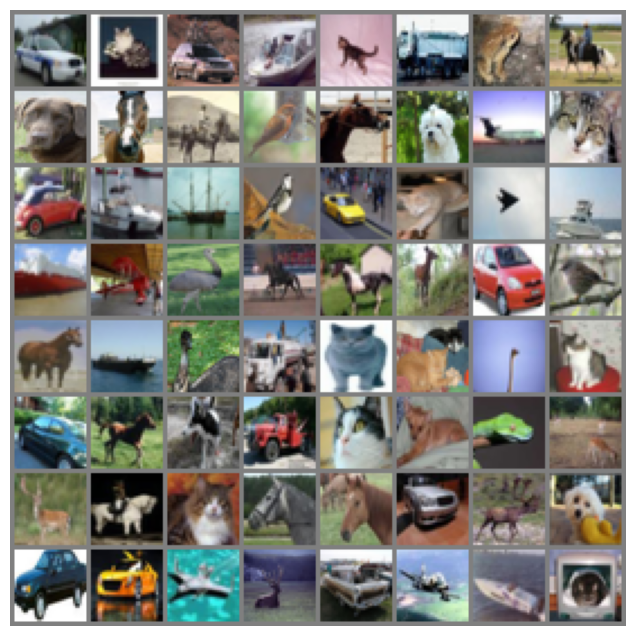

In [4]:
# Get random training images and show them.
images, labels = next(iter(train_loader))
show_image(torchvision.utils.make_grid(images))

## Define a convolutional neural network


**Assignment 1:** Define a convolutional neural network.
You may use the code from previous notebooks.
We suggest that you start with a small network, and make sure that everything is working.
Once you can train successfully, come back and improve the architecture.

In [5]:
class PrintSize(nn.Module):
    """Utility module to print current shape of a Tensor in Sequential, only at the first pass."""

    first = True

    def forward(self, x):
        if self.first:
            print(f"Size: {x.size()}")
            self.first = False
        return x


class Model(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        # Your code here!
        self.act_fn = nn.LeakyReLU(negative_slope=0.01)

        # Structure: Conv -> BatchNorm -> Activation -> MaxPool
        self.conv_block1 = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=3, padding=1),
                nn.BatchNorm2d(64),
                self.act_fn,
                nn.MaxPool2d(2, 2)
        )

        self.conv_block2 = nn.Sequential(
                nn.Conv2d(64, 128, kernel_size=3, padding=1),
                nn.BatchNorm2d(128),
                self.act_fn,
                nn.MaxPool2d(2, 2)
        )

        self.conv_block3 = nn.Sequential(
                nn.Conv2d(128, 256, kernel_size=3, padding=1),
                nn.BatchNorm2d(256),
                self.act_fn,
                nn.MaxPool2d(2, 2)
        )

        self.conv_block4 = nn.Sequential(
                nn.Conv2d(256, 512, kernel_size=3, padding=1),
                nn.BatchNorm2d(512),
                self.act_fn,
                nn.MaxPool2d(2, 2)
        )

        # Fully connected output block
        self.fc_block = nn.Sequential(
            nn.Linear(512//4 * 4 * 4, 256),
            nn.BatchNorm1d(256),
            self.act_fn,
            nn.Linear(256, self.num_classes)
        )

        # Layer for book exercise 6.1
        self.softmax = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512//4 * 4 * 4, self.num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        # Your code here!
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)

        # Calling to the layer for the additional exercise from the book
        # Placed here to avoid the fully connected layer coming after
        # return self.softmax(x)

        x = x.view(x.size(0), -1) # flatten output for FC block
        x = self.fc_block(x)

        return F.log_softmax(x, dim=1)


model = Model(n_classes)
device = torch.device('cpu')  # use cuda or cpu
model.to(device)
print(model)

Model(
  (act_fn): LeakyReLU(negative_slope=0.01)
  (conv_block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil

## Define a loss function and optimizer

**Assignment 2:** Define the loss function and optimizer.
You might need to experiment a bit with the learning rate.

In [6]:
loss_fn = nn.CrossEntropyLoss() # Your code here!
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-8) # Your code here!

## Train the network

**Assignment 3:** Finish the training loop below.
Start by using a small number of epochs (e.g. 2).
Even with a low number of epochs you should be able to see results that are better than chance.
When everything is working increase the number of epochs to find out how good your network really is.

In [7]:
# Test the forward pass with dummy data
out = model(torch.randn(2, 3, 32, 32, device=device))
print("Output shape:", out.size())
print(f"Output logits:\n{out.detach().cpu().numpy()}")
print(f"Output probabilities:\n{out.softmax(1).detach().cpu().numpy()}")

Output shape: torch.Size([2, 10])
Output logits:
[[-2.6691031 -2.38757   -1.5263436 -2.8455703 -2.0903928 -2.4472191
  -1.9554511 -3.1914814 -2.4685643 -2.4544234]
 [-2.3669417 -1.7583185 -2.6441464 -2.3812156 -2.6287704 -2.3320222
  -2.6427813 -2.2245047 -2.758709  -1.8421862]]
Output probabilities:
[[0.06931437 0.09185263 0.21732886 0.05810112 0.12363856 0.08653389
  0.14150062 0.04111093 0.08470639 0.08591272]
 [0.09376705 0.17233439 0.07106598 0.09243815 0.07216714 0.0970992
  0.07116307 0.10812096 0.06337354 0.15847059]]


In [8]:
batch_size = 64
num_epochs = 10
validation_every_steps = 500

step = 0
model.train()

train_accuracies = []
valid_accuracies = []

for epoch in range(num_epochs):

    train_accuracies_batches = []

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass, compute gradients, perform one training step.
        # Your code here!
        output = model(inputs)
        loss = loss_fn(output, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Increment step counter
        step += 1

        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))

        if step % validation_every_steps == 0:

            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))

            train_accuracies_batches = []

            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = model(inputs)
                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))

                model.train()

            # Append average validation accuracy to list.
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(test_set))

            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             test accuracy: {valid_accuracies[-1]}")

print("Finished training.")

Step 500     training accuracy: 0.5671875
             test accuracy: 0.6561
Step 1000    training accuracy: 0.7355934633027523
             test accuracy: 0.682
Step 1500    training accuracy: 0.74578125
             test accuracy: 0.7231
Step 2000    training accuracy: 0.8192373853211009
             test accuracy: 0.7414
Step 2500    training accuracy: 0.8828125
             test accuracy: 0.7415
Step 3000    training accuracy: 0.86865625
             test accuracy: 0.7516
Step 3500    training accuracy: 0.922883064516129
             test accuracy: 0.7588
Step 4000    training accuracy: 0.9555555555555556
             test accuracy: 0.76
Step 4500    training accuracy: 0.9524375
             test accuracy: 0.765
Step 5000    training accuracy: 0.9751420454545454
             test accuracy: 0.772
Step 5500    training accuracy: 0.9597355769230769
             test accuracy: 0.7529
Step 6000    training accuracy: 0.97871875
             test accuracy: 0.7666
Step 6500    training acc

## Test the network

Now we show a batch of test images and generate a table below with the true and predicted class for each of these images.

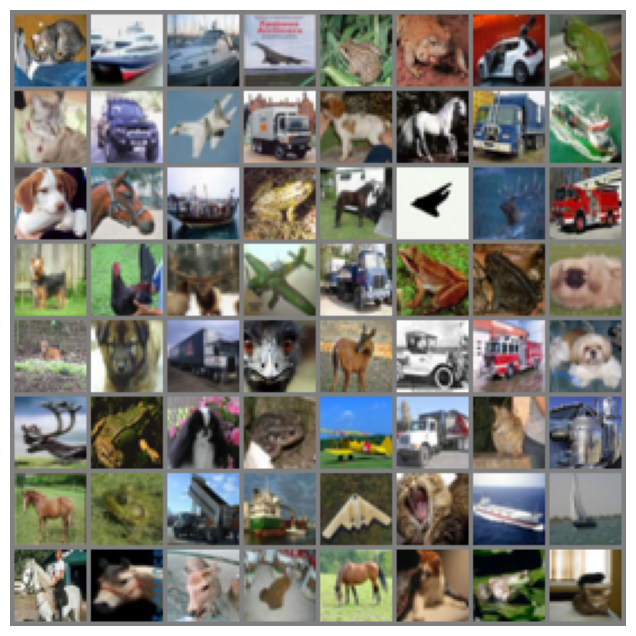

    TRUE        PREDICTED
-----------------------------
     cat           cat     
    ship          ship     
    ship       automobile  
  airplane      airplane   
    frog          frog     
    frog          frog     
 automobile    automobile  
    frog        airplane   
     cat           cat     
 automobile    automobile  
  airplane      airplane   
    truck         truck    
     dog           dog     
    horse         horse    
    truck         truck    
    ship          ship     
     dog           dog     
    horse          dog     
    ship          ship     
    frog          frog     
    horse         horse    
  airplane        bird     
    deer        airplane   
    truck         truck    
     dog          deer     
    bird          bird     
    deer           cat     
  airplane      airplane   
    truck         truck    
    frog          frog     
    frog          frog     
     dog           dog     
    deer          bird     
     dog           d

In [9]:
inputs, targets = next(iter(test_loader))
inputs, targets = inputs.to(device), targets.to(device)
show_image(make_grid(inputs))
plt.show()

outputs = model(inputs)
_, predicted = torch.max(outputs.data, 1)

print("    TRUE        PREDICTED")
print("-----------------------------")
for target, pred in zip(targets, predicted):
    print(f"{classes[target.item()]:^13} {classes[pred.item()]:^13}")

We now evaluate the network as above, but on the entire test set.

In [15]:
# Evaluate test set
confusion_matrix = np.zeros((n_classes, n_classes))
with torch.no_grad():
    model.eval()
    test_accuracies = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        output = model(inputs)
        loss = loss_fn(output, targets)

        predictions = output.max(1)[1]

        # Multiply by len(inputs) because the final batch of DataLoader may be smaller (drop_last=True).
        test_accuracies.append(accuracy(targets, predictions) * len(inputs))

        confusion_matrix += compute_confusion_matrix(targets, predictions)

    test_accuracy = np.sum(test_accuracies) / len(test_set)

    model.train()

Here we report the **average test accuracy** (number of correct predictions divided by test set size).

In [16]:
print(f"Test accuracy: {test_accuracy*100:.1f}%")

Test accuracy: 75.0%


Here we look a bit more in depth into the performance of the classifier, using the **confusion matrix**. The entry at the i-th row and j-th column indicates the number of samples with true label being the i-th class and predicted label being the j-th class.

We normalize the rows: given all examples of a specific class (row), we can observe here how they are classified by our model. Ideally, we would like the entries on the diagonals to be 1, and everything else 0. This would mean that all examples from that class are classified correctly.

The classes that are harder to classify for our model have lower numbers on the diagonal. We can then see exactly *how* they are misclassified by looking at the rest of the row.


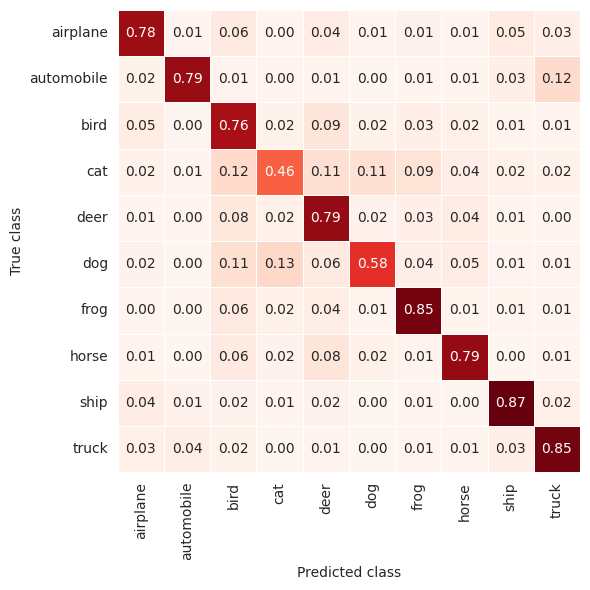

In [17]:
def normalize(matrix, axis):
    axis = {'true': 1, 'pred': 0}[axis]
    return matrix / matrix.sum(axis=axis, keepdims=True)

x_labels = [classes[i] for i in classes]
y_labels = x_labels
plt.figure(figsize=(6, 6))
sns.heatmap(
    ax=plt.gca(),
    data=normalize(confusion_matrix, 'true'),
    annot=True,
    linewidths=0.5,
    cmap="Reds",
    cbar=False,
    fmt=".2f",
    xticklabels=x_labels,
    yticklabels=y_labels,
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.tight_layout()
plt.show()

Here we focus on the diagonal and plot the numbers in a bar plot. This gives us a clearer picture of the accuracy of the model for different classes.

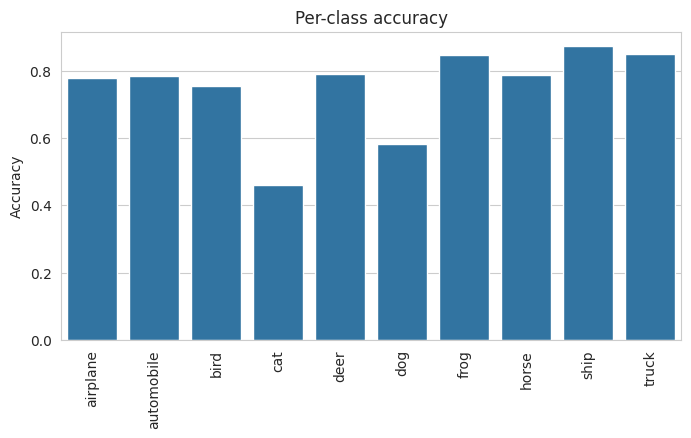

In [18]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(8, 4))
    sns.barplot(x=x_labels, y=np.diag(normalize(confusion_matrix, 'true')))
    plt.xticks(rotation=90)
    plt.title("Per-class accuracy")
    plt.ylabel("Accuracy")
    plt.show()

**Assignment 4:**
1. Go back and improve performance of the network. By using enough convolutional layers with enough channels (and by training for long enough), you should easily be able to get a test accuracy above 60%, but see how much further you can get it! Can you reach 70%?

2. Briefly describe what you did and any experiments you did along the way as well as what results you obtained.
Did anything surprise you during the exercise?
What were the changes that seemed to improve performance the most?

3. Write down key lessons/insights you got during this exercise.

**Answer:** <br>
So I tried to add more convolutional layers and also made them more complex by having max pooling and batch normalization in each. I had some problems getting the dimensions to fit, especially going from the convolutional block to the linear. I realized that the problem arose from the last max pooling layer in the final convolutional block that I had copied from the previous ones, and it made the final dimension four times smaller. I also tried different activation functions and softmax variation and was pretty satisfied with the current combination. The loss function and optimizer I didn't play too much with after already having done to in the last exercise. I do get a test accuracy at 75%.

More training epochs could be an alternative to changing the architecture more, but based on the last four epochs the accuracies doesn't seem to change much in the same direction but fluctuate back and forth. This might indicate the network is close to convergence or would need an excess amout of time to learn something new.

Looking at the heatmap and barplot it can be seen that the classes the model fails most often on are at predicting dogs and cats. However, this doesn't necessarily mean the model misses when predicting these animals. Looking closer at the list of predictions from the model, it can be found that it often guesses on these classes when predicting e.g. a horse or deer thus lowering the overall accuracy of that class. This means there are still some features for the model to improve on, when classifying especially animal images.

In general, I got a deeper understanding of CNNs and the necessity to know your matrix multiplications.

# Training on GPU

**Optional Assignment:**
If you have a GPU, we suggest that you try training your model on GPU. For this, you need to move the model to GPU after defining it, which will recursively go over all modules and convert their parameters and buffers to CUDA tensors. You also need to transfer both the inputs and targets to GPU at each training step, before performing the forward pass.

The code for this is already in place: notice the `.to(device)` statements. The only thing left to do is change the definition of `device` from `'cpu'` to `'cuda'`.

If you don't have a GPU, you can do this on [Google Colab](https://research.google.com/colaboratory/).

Use the code below to check if any GPU is avaiable in your current setup. This should print the models of all available GPUs.


In [5]:
# Check if we have GPUs available
print("Available CUDA devices:", [torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())])

Available CUDA devices: []


You may not notice any significant speed-up from using a GPU. This is probably because your network is really small. Try increasing the width of your network (number of channels in the convolutional layers) and see if you observe any speed-up on GPU compared to CPU.

# Exercise from Michael Nielsen's book

**Assignment 5:** Pick an exercise of your own choice from [Michael Nielsen's book](http://neuralnetworksanddeeplearning.com/).

**Answer:** <br>
I chose to answer Exercise 6.1, so the one exercise from chapter 6. The problem description is:
- *What classification accuracy do you get if you omit the fully-connected layer, and just use the convolutional-pooling layer and softmax layer? Does the inclusion of the fully-connected layer help?*

To answer the question and solve the exercise I have change the network architecture in the model definition. The relevant code for that is shown by comments. So instead of having a fully connected layer between the last convolution block and the output, it instead goes directly into a variation of output block altered to accomendate for the changed architecture.

This change gives a test accuracy of merely 12% instead of the previous 75%, which is a clear decrease in performance. Actually, it just corresponds to randomly guessing, meaning the network isn't learning anything. This shows that this connection layer seems to be highly relevant for conveying the relevant and necessary information from the convolution over to the output.
